# 1. Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from feature_engine.datetime import DatetimeFeatures
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve
import warnings
warnings.filterwarnings('ignore')


# 2. Display Settings

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
# Convert all the output of sklearn from numpy to pandas
# sklearn.set_config(transform_output="pandas")
sklearn.set_config(transform_output="default")

# 3. Getting the Data

In [4]:
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")
test_df = pd.read_csv("data/test.csv")

In [5]:
train_df

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included,4995
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info,8372
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info,6117
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info,7770
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info,9187
...,...,...,...,...,...,...,...,...,...,...
635,Air Asia,2019-04-12,Banglore,Delhi,04:55:00,07:45:00,170,0.0,No Info,4282
636,Jet Airways,2019-05-09,Kolkata,Banglore,09:35:00,21:05:00,690,1.0,No Info,13067
637,Indigo,2019-05-15,Banglore,Delhi,06:05:00,08:50:00,165,0.0,No Info,4423
638,Multiple Carriers,2019-05-15,Delhi,Cochin,08:45:00,21:00:00,735,1.0,No Info,7670


## 3.1 Split the data

In [6]:
X_train = train_df.loc[:, train_df.columns != 'price']
y_train = train_df[['price']]

In [7]:
X_val = val_df.loc[:, val_df.columns != 'price']
y_val = val_df[['price']]

In [8]:
X_test = test_df.loc[:, test_df.columns != 'price']
y_test = test_df[['price']]

## 3.2 Meta-info()

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


# 4. Data Preprocessing


In [10]:
# Extracting the name of the number columns
num_cols = list(X_train.select_dtypes(include=np.number).columns)
# Extracting time columns
dt_cols = ["date_of_journey", "arrival_time", "dep_time"]
# Extracting categorical column
cat_cols = list(set(X_train.columns) - set(num_cols) - set(dt_cols))

In [11]:
num_cols

['duration', 'total_stops']

In [12]:
cat_cols

['airline', 'source', 'destination', 'additional_info']

In [13]:
# Creating a Pipeline for Categorical, Numerical Columns
num_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())]
                   )

cat_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown="ignore"))]
                   )
doj_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract=["month", "week", "day_of_week", "day_of_month"], format = "mixed")),
    ('scaler', StandardScaler())]
                          )
time_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract=["hour", "minute"], format = "mixed")),
    ('scaler', StandardScaler())]
                          )

In [14]:
cat_cols

['airline', 'source', 'destination', 'additional_info']

In [15]:
preprocessor = ColumnTransformer(transformers = [
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols),
    ("doj", doj_transformer, ["date_of_journey"]),
    ("time", time_transformer, ["dep_time", "arrival_time"])
])

In [16]:
# preprocessor.fit_transform(X_train).info()

# 5. Model Selection

In [17]:
algorithms = {
    "Linear Regression": LinearRegression(),
    "Support Vector Machine": SVR(),
    "Random Forest": RandomForestRegressor(n_estimators=10),
    "XG Boost": XGBRegressor(n_estimators=10)
}

In [18]:
data = pd.concat([train_df, val_df], axis=0)

In [19]:
X_data = data.loc[:, val_df.columns != 'price']
y_data = data[['price']]

In [20]:
def plot_curves(sizes, mean_scores, std_scores, label, ax):
    
    ax.plot( sizes, mean_scores, marker = "o", label=label)
    ax.fill_between(x= sizes,
                    y1=mean_scores - std_scores,
                    y2=mean_scores + std_scores, alpha =0.5)



In [21]:
def plot_learning_curves(name, algorithm, figsize=(12, 4)):
    model = Pipeline(steps=[
        ("pre", preprocessor),
        ("alg", algorithm)
    ])
    
    
    train_sizes, train_scores, test_scores = learning_curve( estimator=model,
                                                           X=X_data,
                                                           y=y_data,
                                                           cv=2,
                                                           scoring="r2",
                                                           n_jobs= -1,
                                                           random_state=42)
    mean_train_scores = np.mean(train_scores, axis=1)
    std_train_scores = np.std(train_scores, axis=1)
    train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}" 

    
    mean_test_scores = np.mean(test_scores, axis=1)
    std_test_scores = np.std(test_scores, axis=1)
    test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"
    print(test_score)

    fig, ax = plt.subplots(figsize=figsize)

    # Training cure
    plot_curves(train_sizes, mean_train_scores, std_train_scores,f"Train({train_score})", ax)
    plot_curves(train_sizes, mean_test_scores, std_test_scores,f"Train({test_score})", ax)

    ax.set(xlabel="Training Set Size", ylabel="R-Square", title=name)

    plt.show()

0.66 +/- 0.01


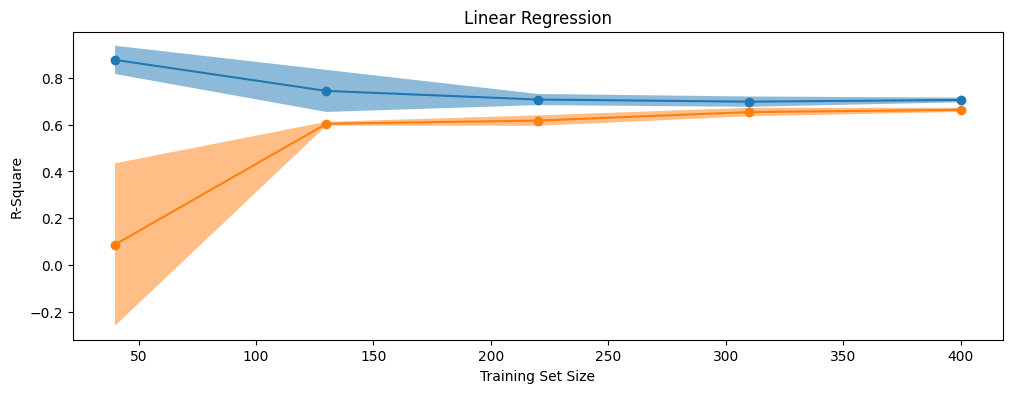

/Users/vinaymittal/anaconda3/envs/new_env_name/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vinaymittal/anaconda3/envs/new_env_name/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vinaymittal/anaconda3/envs/new_env_name/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vinaymittal/anaconda3/envs/new_env_name/lib/python3.9/site-packages/sklearn/utils/validation.py:130

-0.02 +/- 0.01


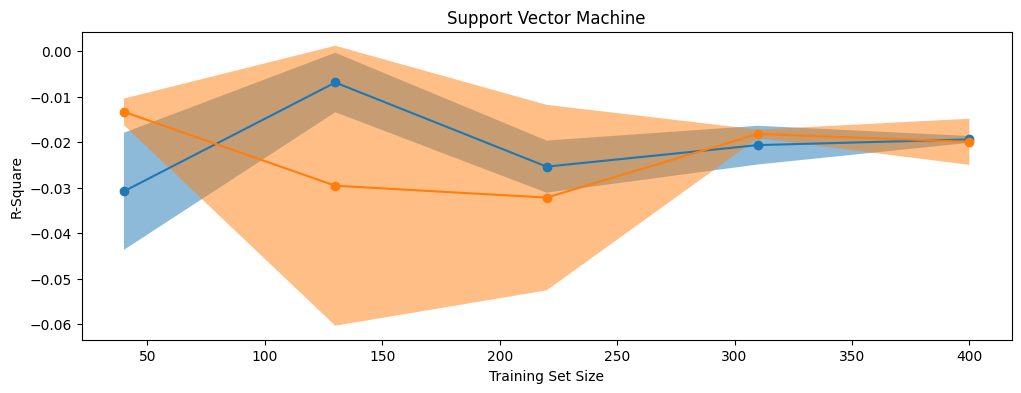

/Users/vinaymittal/anaconda3/envs/new_env_name/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/vinaymittal/anaconda3/envs/new_env_name/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/vinaymittal/anaconda3/envs/new_env_name/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/vinaymittal/anaconda3/envs/new_env_name/lib/python3.9/site-packages/sklearn/base.py:1474: Dat

0.64 +/- 0.05


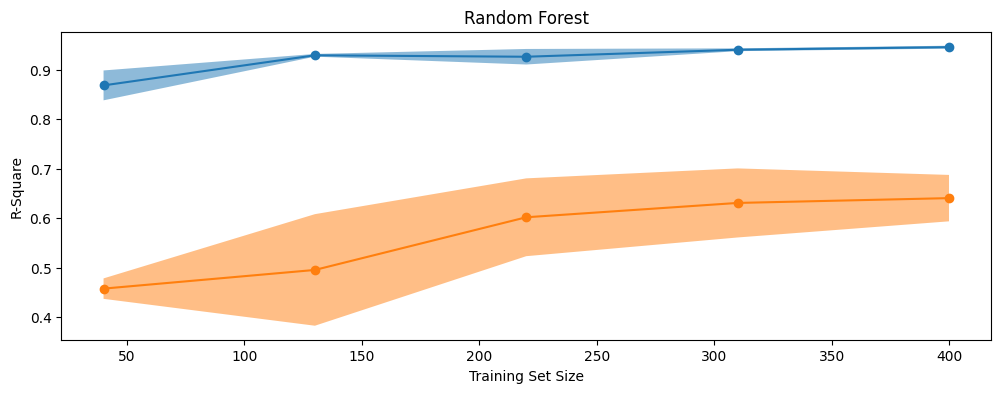

0.63 +/- 0.08


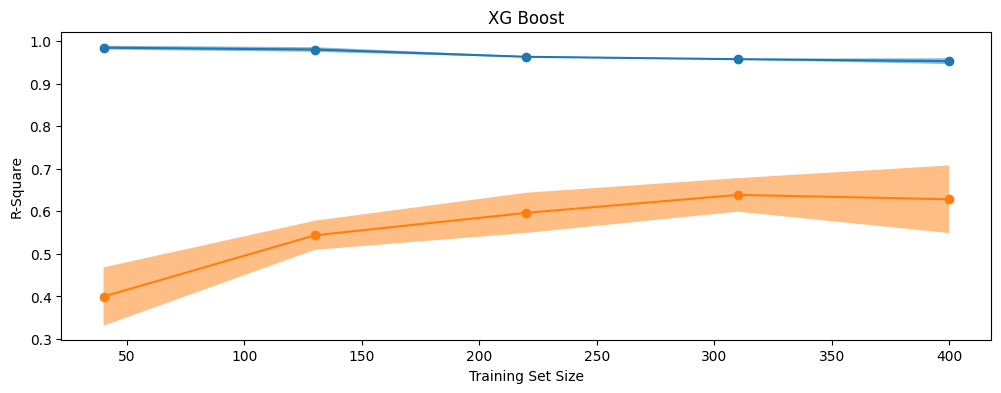

In [22]:
for name, alg in algorithms.items():
    plot_learning_curves(name, alg)

# 6. Model Training

In [23]:
model = Pipeline(steps=[
    ("pre", preprocessor),
    ("alg", RandomForestRegressor(n_estimators=10))
])

In [24]:
model.fit(X_data, y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('alg', RandomForestRegressor(n_estimators=10))])

# 7. Model Evaluation

In [25]:
def evaluate_model(X, y):
    y_pred = model.predict(X)
    return r2_score(y, y_pred)

In [26]:
print(evaluate_model(X_data, y_data))
print(evaluate_model(X_test, y_test))

0.9488783062370442
0.7348112689782256


# 8. Model Persistance

In [27]:
joblib.dump(model, "model.joblib")

['model.joblib']

In [28]:
saved_model = joblib.load("model.joblib")